In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os, re
import glob
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2 
from scipy import signal, fftpack
import warnings
import sklearn.model_selection as model_selection
import sklearn.utils as utils
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import itertools as it
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
import seaborn as sns
sns.set()
sns.set_context('talk')
warnings.filterwarnings('ignore')

from braintv_ephys_dev.workstation.danield import generalephys as ephys
import braintv_ephys_dev.workstation.danield.continuous_traces as traces
import braintv_ephys_dev.workstation.danield.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Testing Data Functions

In [144]:
def prep_one_probe_test_data(filepath, bandtype):
    if bandtype == 'lfp':
        retrieval_samp_rate = 2500
        fft_samp_rate = 1000
        cutoff_freq = 0.5
        get_powers_between = (0, 4000) # corresponds to 0 to 500 Hz
    elif bandtype == 'spikeband':
        retrieval_samp_rate = 30000
        fft_samp_rate = 4000
        cutoff_freq = 10
        get_powers_between = (6400, 16000) # corresponds to 800 to 2000 Hz
    else:
        raise Exception('not valid band type: \'lfp\' or \'spikeband\'')
        
    resamped_channel_signal = get_filtered_signal(filepath, retrieval_samp_rate, fft_samp_rate, cutoff_freq)
    fft_chunk = get_fft(resamped_channel_signal, fft_samp_rate, get_powers_between)
    features_norm = normalize(fft_chunk)
    
    return features_norm


def get_filtered_signal(filepath, retrieval_samp_rate, fft_samp_rate, cutoff_freq):
    t1, t2 = 3., 11.
    
    mm = np.memmap(filepath, dtype=np.int16, mode='r')
    num_channels = traces.get_channel_count(filepath.rsplit(os.path.sep,1)[0], from_channel_map=False) 
    chunk = traces.get_chunk(mm, t1, t2, num_channels, sampling_rate=retrieval_samp_rate)
    
    for skip in sorted(traces.skip_channels, reverse=True):
        if len(chunk) > skip:
            chunk = np.delete(chunk, skip, 0)
    
    resamped_combined = np.empty((0, int((t2 - t1) * fft_samp_rate)), dtype=np.int16)
    for j in range(chunk.shape[0]):
        channel_signal = bessel_highpass_filter(chunk[j,:], cutoff_freq, retrieval_samp_rate, order=5)
        resamped_channel_signal = signal.resample(channel_signal, int((t2 - t1) * fft_samp_rate))
        resamped_combined = np.append(resamped_combined, np.expand_dims(resamped_channel_signal, axis=0), axis=0)
        
    return resamped_combined


def get_fft(resamped_channel_signal, fft_samp_rate, get_powers_between):
    t1, t2 = 3., 11.
    
    fft_chunk = np.empty((0, int(get_powers_between[1] - get_powers_between[0])), dtype=np.int16)

    for i in range(int(resamped_channel_signal.shape[0])):
        fft = abs(fftpack.fft(resamped_channel_signal[i,:]))
        fft_chunk = np.append(fft_chunk, np.expand_dims(fft[get_powers_between[0]:get_powers_between[1]], axis=0), axis=0)
        
    return fft_chunk


def normalize(features):
    features_norm = np.zeros(features.shape)

    for j in range(int(features.shape[1])):
        features_norm[:,j] = (features[:,j] - np.mean(features[:,j])) / np.std(features[:,j])
    
    return features_norm


def bessel_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.bessel(order, normal_cutoff, btype='highpass', analog=False)
    w, h = signal.freqs(b, a)
    
    return b, a


def bessel_highpass_filter(data, cutoff, fs, order=5):
    b, a = bessel_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    
    return y

## Etc. Functions

In [145]:
def shuffle_data(features, targets):
    if features.shape[0] != targets.shape[0]:
        raise Exception('arguments not equal length')
        
    shuffle_array = np.array([[np.random.rand()] for i in range(features.shape[0])])
    shuffled_lists = sorted(zip(features, targets, shuffle_array), key=lambda x: x[2])
    features, targets, shuffled_array = [[x[i] for x in shuffled_lists] for i in range(3)]
    return np.array(features), np.array(targets)

## Prep Training Data

In [146]:
training_data_lfp = pd.read_pickle('chunked_fft_data_lfp.pkl')
training_features_lfp = training_data_lfp.drop('targets',axis=1).as_matrix().astype(np.float32)
training_targets_lfp = training_data_lfp.as_matrix(columns=['targets'])
print(training_features_lfp.shape)
print(training_targets_lfp.shape)

training_data_spikeband = pd.read_pickle('chunked_fft_data_spikeband.pkl')
training_features_spikeband = training_data_spikeband.drop('targets',axis=1).as_matrix().astype(np.float32)
training_targets_spikeband = training_data_spikeband.as_matrix(columns=['targets'])
print(training_features_spikeband.shape)
print(training_targets_spikeband.shape)

training_features = np.append(training_features_lfp, training_features_spikeband, axis=1)
training_targets = training_targets_lfp
print(training_features.shape)
print(training_targets.shape)

training_less_targets = np.empty((0,1))
for target in training_targets[:,0]:
    if target == 'above':
        training_less_targets = np.append(training_less_targets, [['above']], axis=0)
    else:
        training_less_targets = np.append(training_less_targets, [['below']], axis=0)

(65L, 4000L)
(65L, 1L)
(65L, 9600L)
(65L, 1L)
(65L, 13600L)
(65L, 1L)


## Prep Test Data

In [352]:
# /Volumes/SD1/DanD/M270512/270512_2016-12-16_10-51-44/
# /Volumes/SD1/DanD/M276039/M276039_2017-02-23_08-55-50/
# /Volumes/SD1/DanD/M310008/M310008_2017-04-12_08-52-48/
# filepath_spikeband = os.path.join('\\\\sd1','sd1','DanD','M276039','M276039_2017-02-23_08-55-50','experiment1_100-0_0.dat')
# filepath_lfp = os.path.join('\\\\sd1','sd1','DanD','M276039','M276039_2017-02-23_08-55-50','experiment1_100-1_0.dat')
filepath_spikeband = os.path.join('\\\\sd1','sd1','DanD','M310008','M310008_2017-04-12_08-52-48','experiment1_102-0_0.dat')
filepath_lfp = os.path.join('\\\\sd1','sd1','DanD','M310008','M310008_2017-04-12_08-52-48','experiment1_102-1_0.dat')
testing_features_lfp = prep_one_probe_test_data(filepath_lfp, 'lfp')
testing_features_spikeband = prep_one_probe_test_data(filepath_spikeband, 'spikeband')

In [353]:
testing_features = np.append(testing_features_lfp, testing_features_spikeband, axis=1)

In [354]:
print testing_features.shape

(195L, 13600L)


## Making SVM

In [355]:
train_x, train_y = shuffle_data(training_features, training_less_targets)
test_x = testing_features
# test_y = testing_less_targets

In [356]:
def make_prediction_svm(train_x, train_y, test_x):
    predictions_total = np.zeros((1, len(test_x)))

    for i in range(50):
        svc = SVC(C=1.0 / ((i + 1) * 5), 
                  kernel='rbf', 
                  degree=3, 
                  gamma=1.0 / 8000, # 1.0 / (5000 - 100 * i), 
                  coef0=0.0, 
                  shrinking=True, 
                  probability=True, 
                  tol=0.0001, 
                  cache_size=200, 
                  class_weight='balanced', 
                  verbose=False, 
                  max_iter=-1, 
                  decision_function_shape='ovr', 
                  random_state=None)

        svc.fit(train_x, train_y)
        predictions = svc.predict(test_x)

        for j, prediction in enumerate(predictions):
            if prediction == 'above':
                predictions_total[0, j] += 1
    
        plt.hold(True)
        plt.plot(predictions_total[0,:] / (i + 1), '--', linewidth=2, alpha=0.5)
    
    predictions_norm = np.zeros(predictions_total.shape)
    predictions_norm[0, :] = (predictions_total[0, :] / max(np.amax(predictions_total[0, :]), 1))
    predictions_norm = np.around(predictions_norm - 0.0)
    
    return predictions_norm

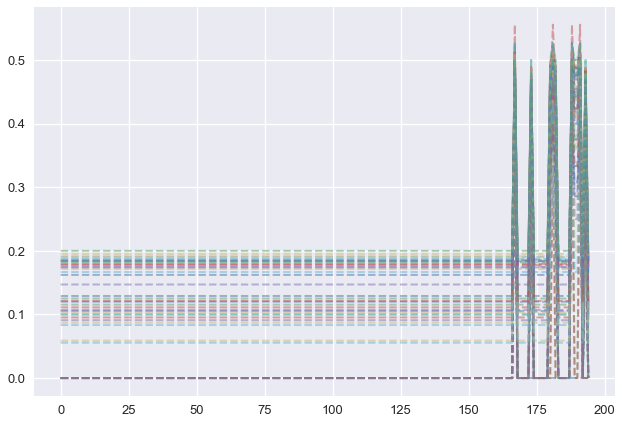

In [357]:
predictions = make_prediction_svm(train_x, train_y, test_x)

In [371]:
first_above = np.where(predictions[0,:] == 1)[0][0]
print float(len(np.where(predictions[0, first_above:] == 1)[0])) / predictions[0, first_above:].shape[0]

0.357142857143


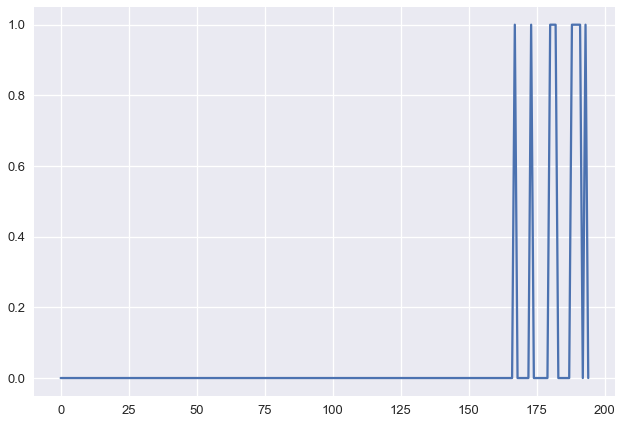

In [359]:
plt.plot(predictions[0,:]);

In [363]:
2.0 / (195 - 164)

0.06451612903225806